# Building a Handwritten Digits Classifier

# Handwritten Digits Classifier

## Challenges of image classification:
- Each pixel is a feature, which means we could have millions of features for one single image (A pixels x B pixels = n features)
- In order to reduce computation times, images are reduced and transformed to grayscale, so there is a loss of detail that hurts our model.
- Non-linear behavior: The features of handwritten digits do not present a linear relationship -pixels will be completely different depending on the number written and the writing itself.

## Deep learning as a solution
Deep learning can learn intermediate representations at each hidden layer we define, identifying patterns in chunks.
To create our handwritten digits classifier, we will use a basic deep learning model.

Using `sklearn.datasets` and `load_digits()` function to return a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import pandas as pd # Data processing
import numpy as np # Linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
# %config InlineBackend.figure_format = 'retina' 
# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['image.cmap'] = 'viridis'

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier


### Helper Functions ###

def explore_number(index,data=load_digits()):
    """Prints following data from digits:
        Numpy 2D array
        Image representation of handwritten number
        Target value (actual number)
    
    Args:
        index of number to be explored
        data (dictionary of data): load_digits() or similar dict structura
    
    Returns:
        Nothing
    """
    print("Handwritten Digit Features - 2D Array")
    print("Target Number {}".format(data['target'][index]))
    print("-------------------------------------")
    for row in data['images'][index]:
        print(row)
    print('\n')
    plt.imshow(data['images'][index], cmap='gray_r')
    plt.xlabel('Target Number {}'.format(data['target'][index]), fontsize=18)
    plt.show()

In [2]:
# Importing the dataset
dataset = load_digits()
dataset.keys() # Keys of dataset

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Handwritten Digit Features - 2D Array
Target Number 6
-------------------------------------
[ 0.  0.  0.  8. 15.  1.  0.  0.]
[ 0.  0.  0. 12. 14.  0.  0.  0.]
[ 0.  0.  3. 16.  7.  0.  0.  0.]
[ 0.  0.  6. 16.  2.  0.  0.  0.]
[ 0.  0.  7. 16. 16. 13.  5.  0.]
[ 0.  0. 15. 16.  9.  9. 14.  0.]
[ 0.  0.  3. 14.  9.  2. 16.  2.]
[ 0.  0.  0.  7. 15. 16. 11.  0.]




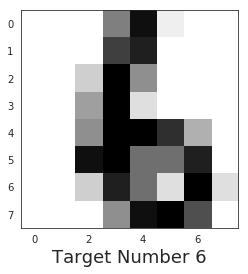

In [3]:
explore_number(16) # Exploring first number's features and target

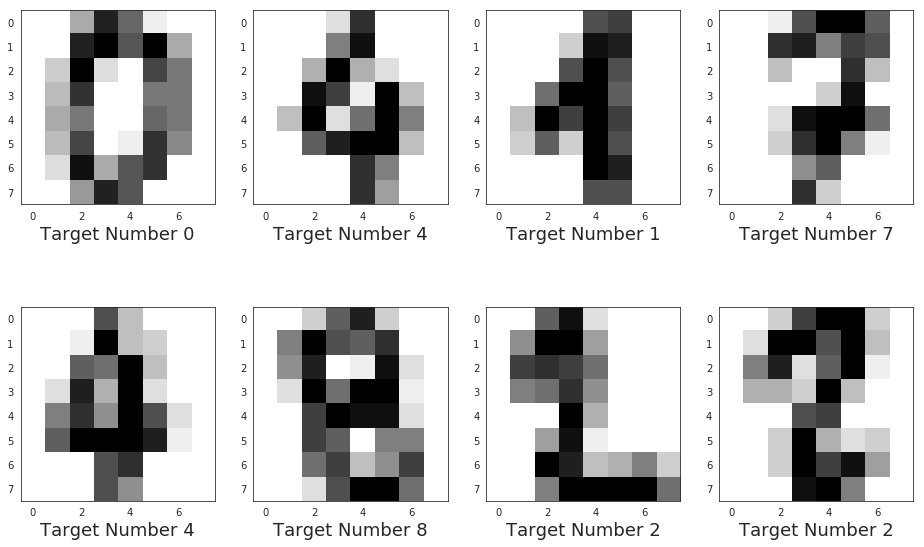

In [4]:
# Visualizing some random data
fig = plt.figure(figsize=(16,10))
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(dataset['images'][i*100], cmap='gray_r') # Showing 2D Numpy arrays as images
    ax.set_xlabel('Target Number {}'.format(dataset['target'][i*100]), fontsize=18) # Add actual number (target) as label

## KNN classifier
In order to make image classification with a KNN algorithm, we will use the features in `dataset['data']` and the target values in `dataset['target']`.

In [5]:
# add to this: either use pandas or use KFold for train and test randomization
train_features = dataset['data'][:1000]
test_features = dataset['data'][1000:]
train_target = dataset['target'][:1000]
test_target = dataset['target'][1000:]


def train(train_features,train_target,k=5):
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(train_features,train_target)
    return knc

def test(train_features,test_features,train_target,test_target,k=5):
    knc = train(train_features,train_target,k)
    predictions = knc.predict(test_features)
    accuracy = cross_val_score(knc,test_features,test_target)
    return accuracy

test(train_features,test_features,train_target,test_target,k=3)


array([0.96666667, 0.92857143, 0.90421456])

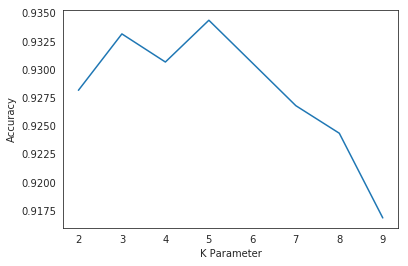

In [6]:
accuracies = list()
accuracies_means = list()

for i in range(2,10):
    accuracy = test(train_features,test_features,train_target,test_target,k=i)
    accuracies.append(accuracy)
    accuracies_means.append(np.mean(accuracy))

plt.xlabel('K Parameter')
plt.ylabel('Accuracy')
plt.plot([i for i in range(2,10)],accuracies_means);

In [7]:
### TO-DO: cross_validate() function and MLP classifier